# 🔩 Boilerplate

In [2]:
# Imports
import os
import random
import matplotlib.pyplot as plt
import cv2
import torch

%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

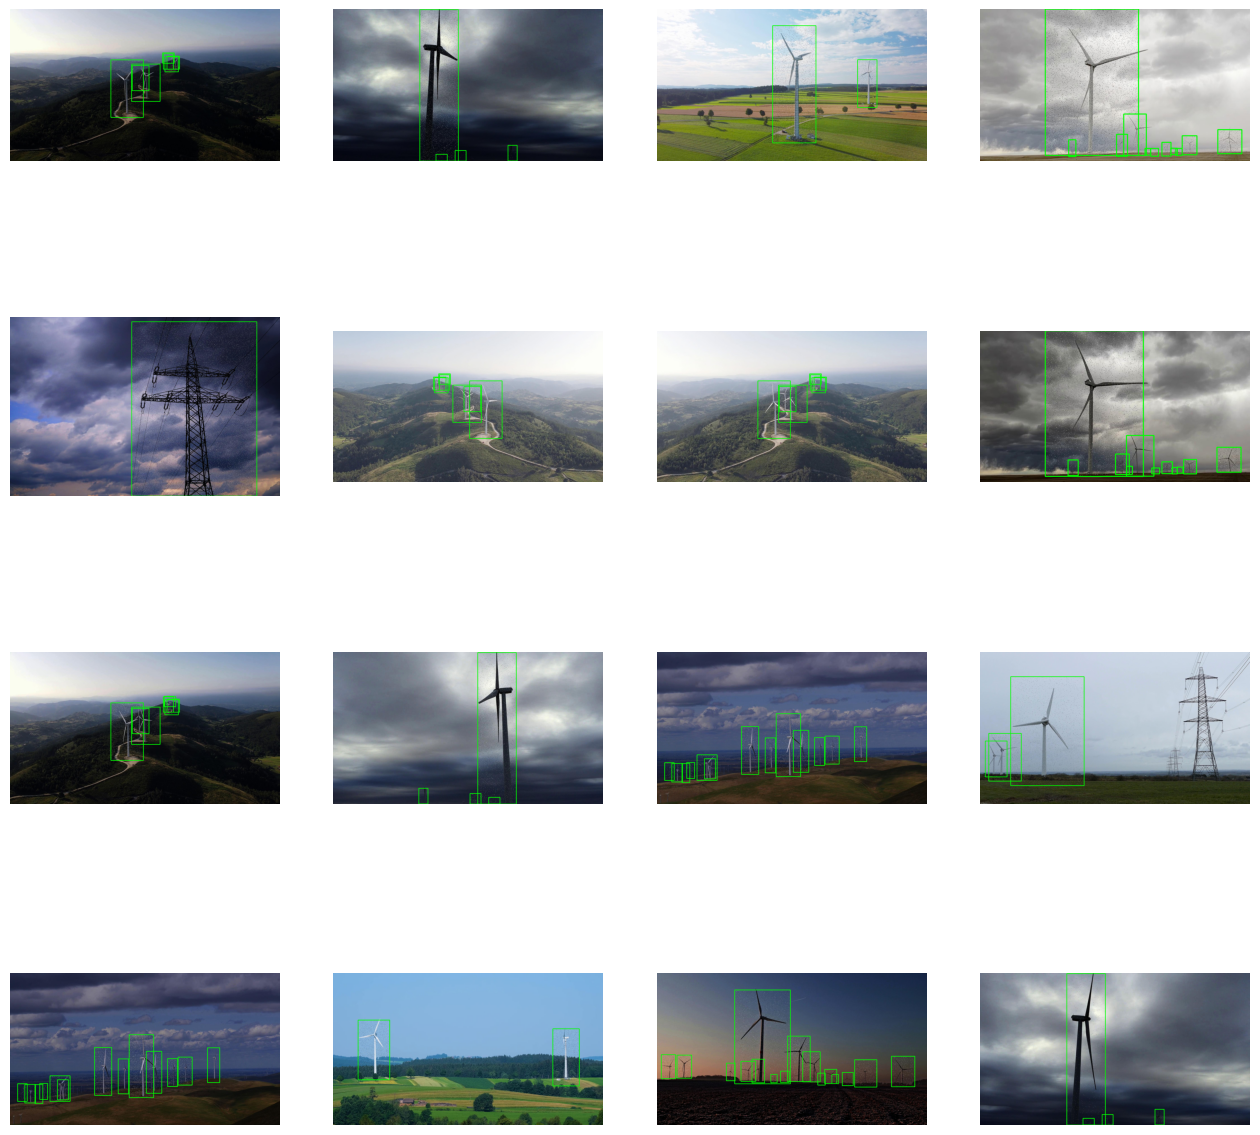

In [7]:
# Download the dataset here: https://www.kaggle.com/datasets/kylegraupe/wind-turbine-image-dataset-for-computer-vision?resource=download

# Define the paths to the images and labels directories
drive_root = "drive/MyDrive/cv_final/"

train_images = f"{drive_root}data/coco/train2017"
train_labels = f"{drive_root}data/coco/train_labels"

test_images = f"{drive_root}data/test/images"
test_labels = f"{drive_root}data/test/labels"

val_images = f"{drive_root}data/coco/val2017"
val_labels = f"{drive_root}data/coco/val_labels"

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

# 💾 Convert data from YOLO to COCO format

In [ ]:
import json

from PIL import Image  # To get image dimensions


def convert_yolo_to_coco(dataset_dir, output_json_path):
    """
    Converts YOLO annotations to COCO format.

    Parameters:
    - dataset_dir: Path to the dataset directory. This directory should contain
      two subdirectories: 'images' and 'labels'.
    - output_json_path: Path where the output COCO-formatted JSON file
      will be saved.
    """
    images_dir = os.path.join(dataset_dir, "images")
    labels_dir = os.path.join(dataset_dir, "labels")

    coco_data = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "windmill"}],
    }

    anno_files = [f for f in os.listdir(labels_dir) if f.endswith(".txt")]

    filename_to_id = {}

    for idx, annotation_file in enumerate(anno_files):
        image_file = annotation_file.replace(
            ".txt", ".jpg"
        )  # Adjust the extension based on your dataset
        image_path = os.path.join(images_dir, image_file)
        image_id = idx + 1

        filename_to_id[annotation_file] = image_id

        with Image.open(image_path) as img:
            width, height = img.size

        coco_data["images"].append(
            {
                "id": image_id,
                "width": width,
                "height": height,
                "file_name": image_file,
            }
        )

        with open(os.path.join(labels_dir, annotation_file), "r") as file:
            for idx, line in enumerate(file.readlines()):
                (
                    class_id,
                    x_center_norm,
                    y_center_norm,
                    width_norm,
                    height_norm,
                ) = map(float, line.split())
                x_min = (x_center_norm - width_norm / 2) * width
                y_min = (y_center_norm - height_norm / 2) * height
                bbox_width = width_norm * width
                bbox_height = height_norm * height

                coco_data["annotations"].append(
                    {
                        "id": len(coco_data["annotations"]) + 1,
                        "image_id": image_id,
                        "category_id": 1,  # Assuming a single category
                        "bbox": [x_min, y_min, bbox_width, bbox_height],
                        "area": bbox_width * bbox_height,
                        "iscrowd": 0,
                    }
                )

    # Save the COCO data to a file
    with open(output_json_path, "w") as json_file:
        json.dump(coco_data, json_file)


# Example usage
# dataset_directory = "/path/to/your/dataset"
# output_json_file = "/path/to/save/coco_annotations.json"
# convert_yolo_to_coco(dataset_directory, output_json_file)


In [ ]:
train_dir = "data/train"
val_dir = "data/valid"
test_dir = "data/test"
output_path = "data/coco"

dirs = [train_dir, val_dir, test_dir]

for dir in dirs:
    output_json_file = os.path.join(output_path, os.path.basename(dir) + ".json")
    convert_yolo_to_coco(dir, output_json_file)

#### Check if the data preprocessing is correct

In [4]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt


def draw_bounding_boxes(image, annotations):
    """
    Draws bounding boxes on the image based on annotation data.

    Parameters:
    - image: The image as a numpy array.
    - annotations: List of annotations, where each annotation contains 'bbox'.
    """
    # Create a figure and axis for the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # For each annotation, add a rectangle for the bounding box
    for ann in annotations:
        # Bounding box [x_min, y_min, width, height]
        bbox = ann["bbox"]
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2],
            bbox[3],
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    plt.show()


In [12]:
data_dir = f"{drive_root}data/coco"
data_type = f"{drive_root}data/coco/train2017"
ann_file = f"{data_dir}/annotations/custom_train.json"

# initialize COCO api for instance annotations
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


In [10]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms = [cat["name"] for cat in cats]
print("Categories: {}".format(nms))

nms = set([cat["supercategory"] for cat in cats if cat.get("supercategory") is not None])
print("Super-categories: {}".format(nms))

Categories: ['windmill']
Super-categories: set()


Image n°2225
Image name: /content/drive/MyDrive/cv_final/data/coco/train2017/windmill33_jpg.rf.65b76099c6a6082c9bc2376ae7913677.jpg


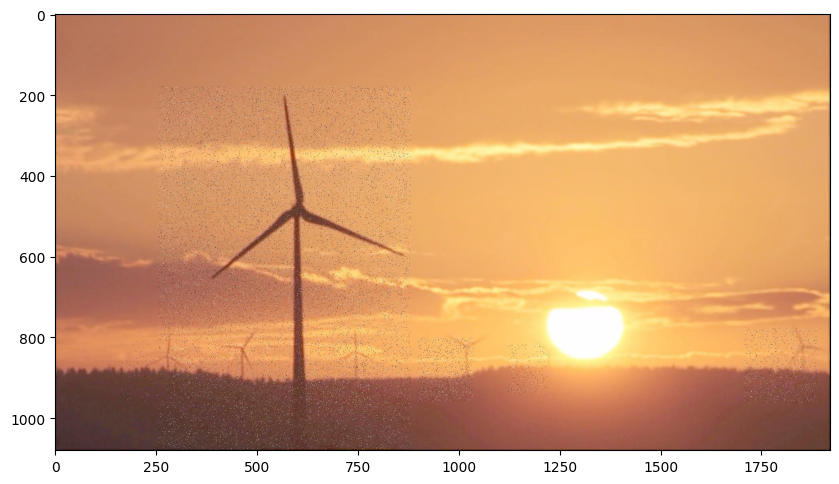

In [13]:
# load and display image
catIds = coco.getCatIds(catNms=["windmill"])
imgIds = coco.getImgIds(catIds=catIds)

img_id = imgIds[np.random.randint(0, len(imgIds))]
print("Image n°{}".format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = "/content/%s/%s" % (data_type, img["file_name"])
print("Image name: {}".format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

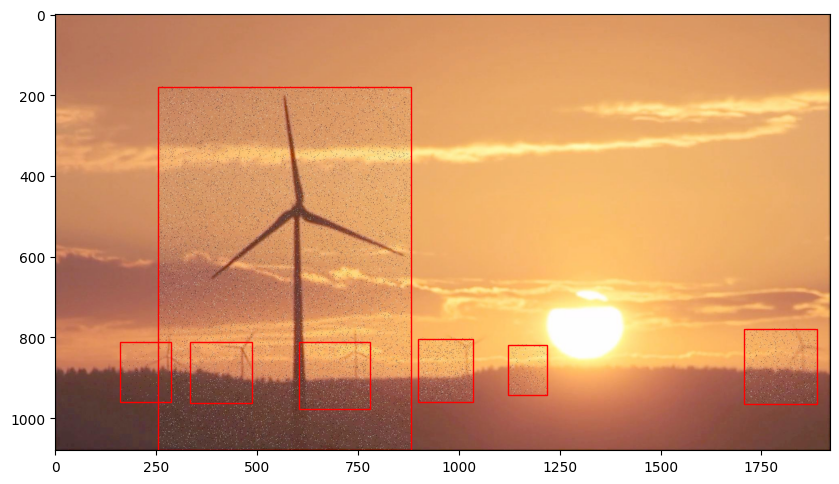

In [14]:
anns = coco.loadAnns(coco.getAnnIds(imgIds=img["id"], catIds=catIds, iscrowd=None))

# Assuming 'I' is your image loaded as a numpy array
# and 'anns' is the list of annotations for that image
draw_bounding_boxes(I, anns)

# 🚵 Model Training

In [15]:
# Clone repo for finetuning DETR on a custom dataset with one class
%cd /content/drive/MyDrive/cv_final

!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

%cd ../

/content/drive/MyDrive/cv_final
Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 263 (delta 4), reused 5 (delta 3), pack-reused 253
Receiving objects: 100% (263/263), 324.61 KiB | 5.32 MiB/s, done.
Resolving deltas: 100% (126/126), done.
/content/drive/MyDrive/cv_final/detr
Already on 'finetune'
Your branch is up to date with 'origin/finetune'.
/content/drive/MyDrive/cv_final


In [56]:
# Load the pre-trained model states
checkpoint = torch.hub.load_state_dict_from_url(
    url="https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth",
    map_location="cpu",
    check_hash=True,
)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Create models folder
!mkdir -p models

# Save
no_class_head_path = "models/detr-no-class-head-2.pth"
torch.save(checkpoint, no_class_head_path)

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth
100%|██████████| 159M/159M [00:01<00:00, 116MB/s]


In [53]:
num_classes = 2
finetuned_classes = ["windmill"]

In [ ]:
!nvidia-smi

Sat Mar  9 00:36:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [57]:
!mkdir -p outputs

%cd detr/

!python main.py \
  --dataset_file "custom" \
  --coco_path "/content/drive/MyDrive/cv_final/data/coco" \
  --output_dir "/content/drive/MyDrive/cv_final/outputs" \
  --resume "/content/drive/MyDrive/cv_final/models/detr-no-class-head-2.pth" \
  --num_classes $num_classes \
  --epochs 5

%cd ../

/content/drive/MyDrive/cv_final/detr
Not using distributed mode
git:
  sha: e891373a8cab93d3719afb0acff28de94c6dc6a3, status: clean, branch: finetune

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=5, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=2, dataset_file='custom', coco_path='/content/drive/MyDrive/cv_final/data/coco', coco_panoptic_path=None, remove_difficult=False, output_dir='/content/drive/MyDrive/cv_final/outputs', device='cuda', seed=42, resume='/content/drive/MyDrive/cv_final/models/detr-no-class-head-2.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url=

In [16]:
from detr.util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('outputs/')]

/content/drive/MyDrive/cv_final/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


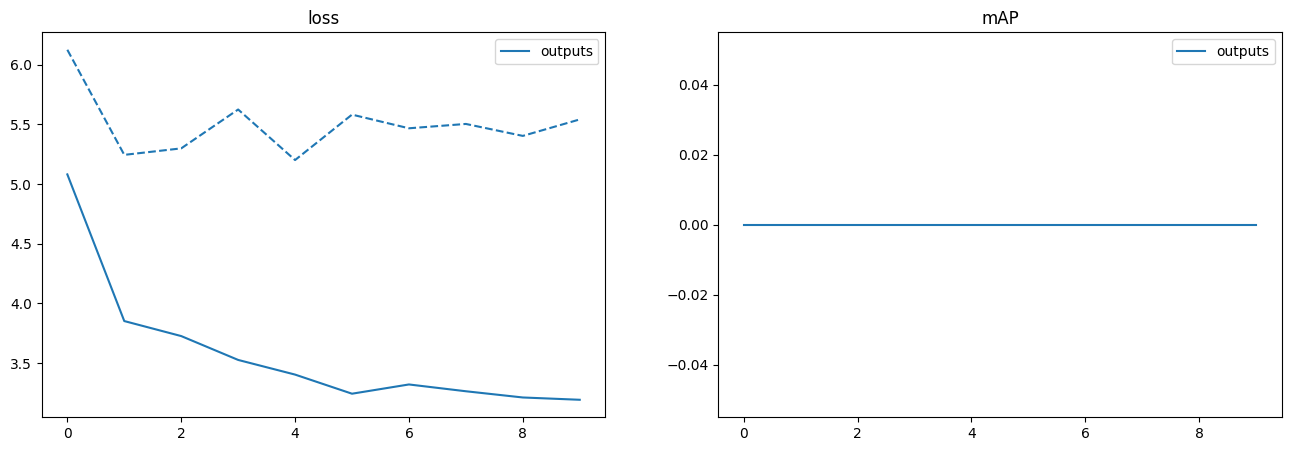

In [17]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

/content/drive/MyDrive/cv_final/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/content/drive/MyDrive/cv_final/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/content/drive/MyDrive/cv_final/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_

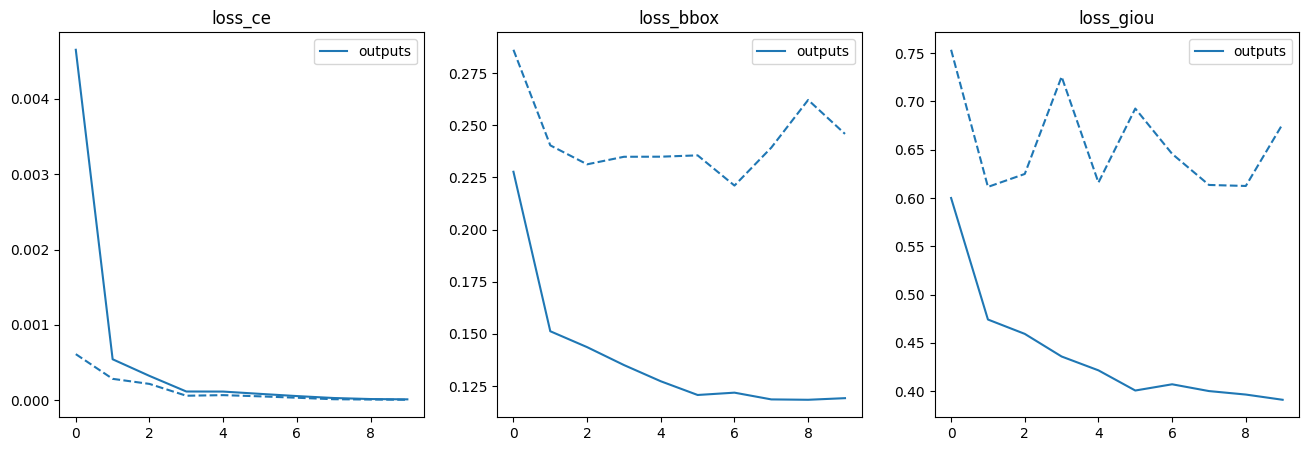

In [ ]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

/content/drive/MyDrive/cv_final/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/content/drive/MyDrive/cv_final/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


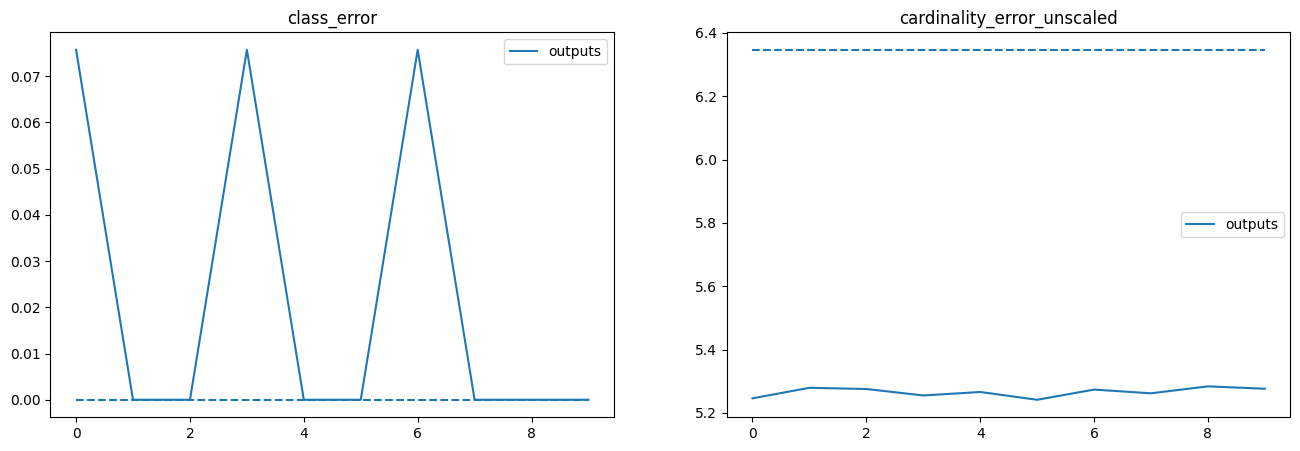

In [ ]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)

In [20]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 85.9MB/s]


In [44]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def filter_bboxes_from_outputs(outputs,
                               threshold=0.7, im=None):

  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  print(probas.max(-1).values)
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  return probas_to_keep, bboxes_scaled

In [22]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [51]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [5e-6]:

    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold, im=my_image)

    plot_finetuned_results(my_image,
                           probas_to_keep,
                           bboxes_scaled)


#### Visualize finetuned results


In [42]:
from PIL import Image

cable_tower_file = "/content/drive/MyDrive/cv_final/data/test/images/cabletower14_jpg.rf.46cdd386dc6936ec89562272d86e72b4.jpg"
windmill_file = "/content/drive/MyDrive/cv_final/data/test/images/windmill29_jpg.rf.a21f26892fe281274b8c834ffc3a4c48.jpg"

cable_im = Image.open(cable_tower_file)
im = Image.open(windmill_file)

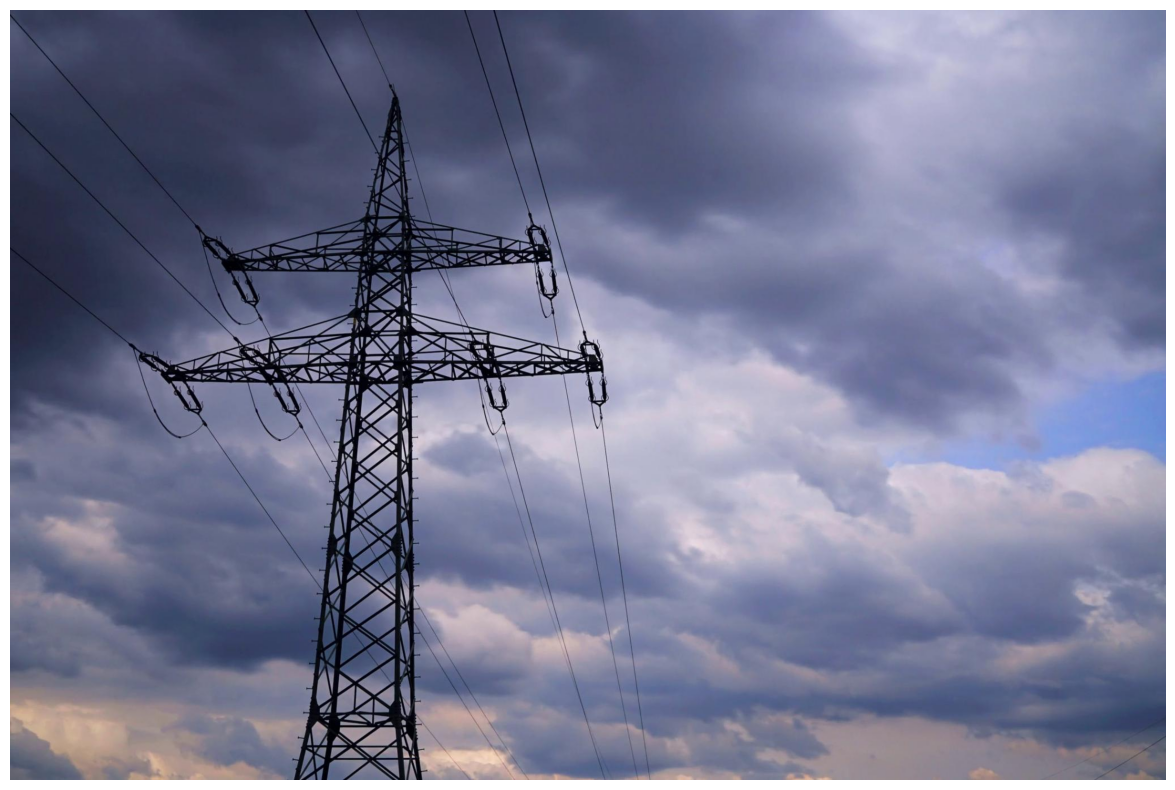

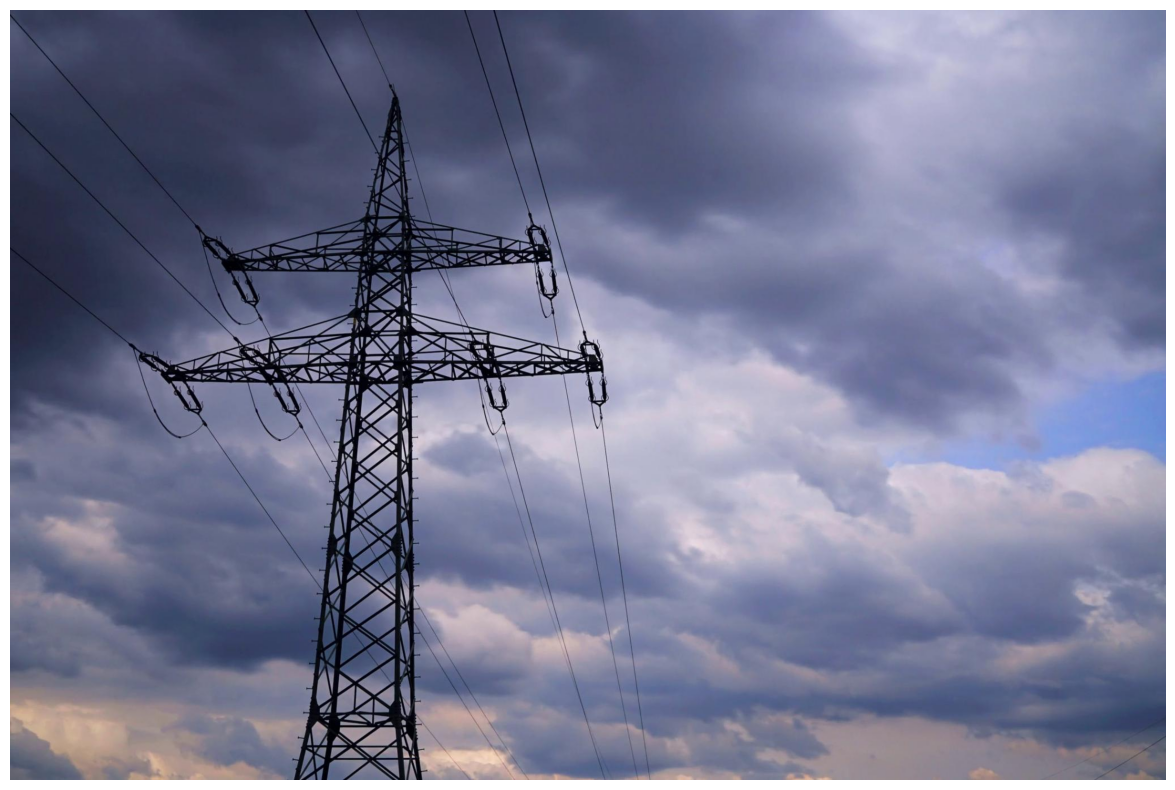

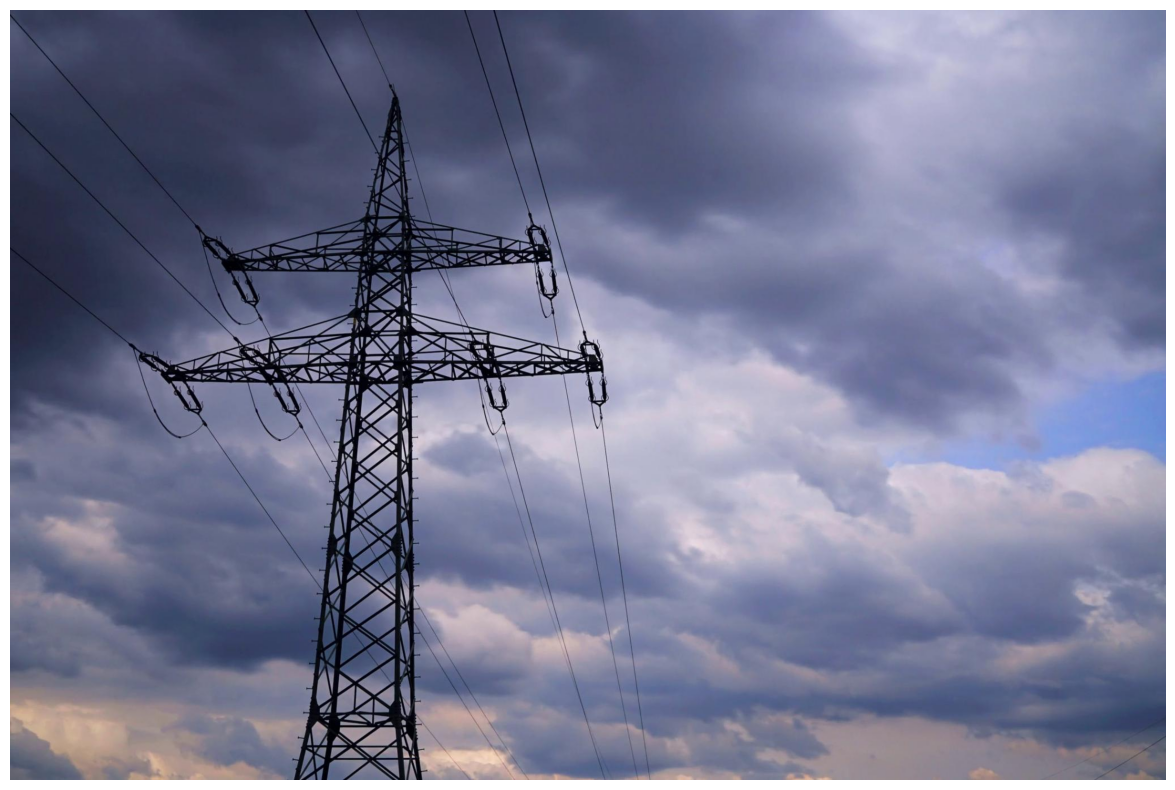

In [38]:
run_worflow(cable_im, model)

tensor([1.6898e-05, 3.9676e-06, 1.9220e-06, 3.6372e-06, 2.3493e-06, 4.5062e-06,
        4.4063e-06, 2.3302e-06, 1.3728e-05, 2.6229e-06, 5.5760e-06, 2.6352e-06,
        2.9309e-06, 6.7706e-06, 5.6472e-06, 2.2572e-06, 1.6799e-05, 2.5790e-06,
        5.0133e-06, 3.2808e-06, 4.6692e-06, 3.4868e-06, 1.2557e-05, 1.3179e-05,
        4.8079e-06, 4.7559e-06, 3.4951e-06, 2.3439e-06, 3.5054e-06, 1.7605e-05,
        3.1384e-06, 4.9337e-06, 2.3363e-06, 4.5113e-06, 3.5594e-06, 4.8066e-06,
        2.8651e-06, 2.2063e-06, 3.5634e-06, 4.1094e-06, 3.3675e-06, 2.9180e-06,
        3.8651e-06, 2.9155e-06, 3.2246e-06, 1.9910e-06, 4.9805e-06, 5.1307e-06,
        2.7102e-06, 1.4563e-06, 3.9739e-06, 3.2140e-06, 2.5994e-06, 2.7988e-06,
        3.1164e-06, 1.9256e-06, 1.3283e-05, 4.4818e-06, 3.9814e-06, 1.7170e-06,
        3.2250e-06, 2.7170e-06, 6.4930e-06, 2.7624e-06, 3.6896e-06, 2.1110e-06,
        3.5409e-06, 3.2559e-06, 2.4496e-06, 1.4394e-05, 1.2463e-05, 2.1232e-06,
        3.5673e-06, 5.0508e-06, 4.5685e-

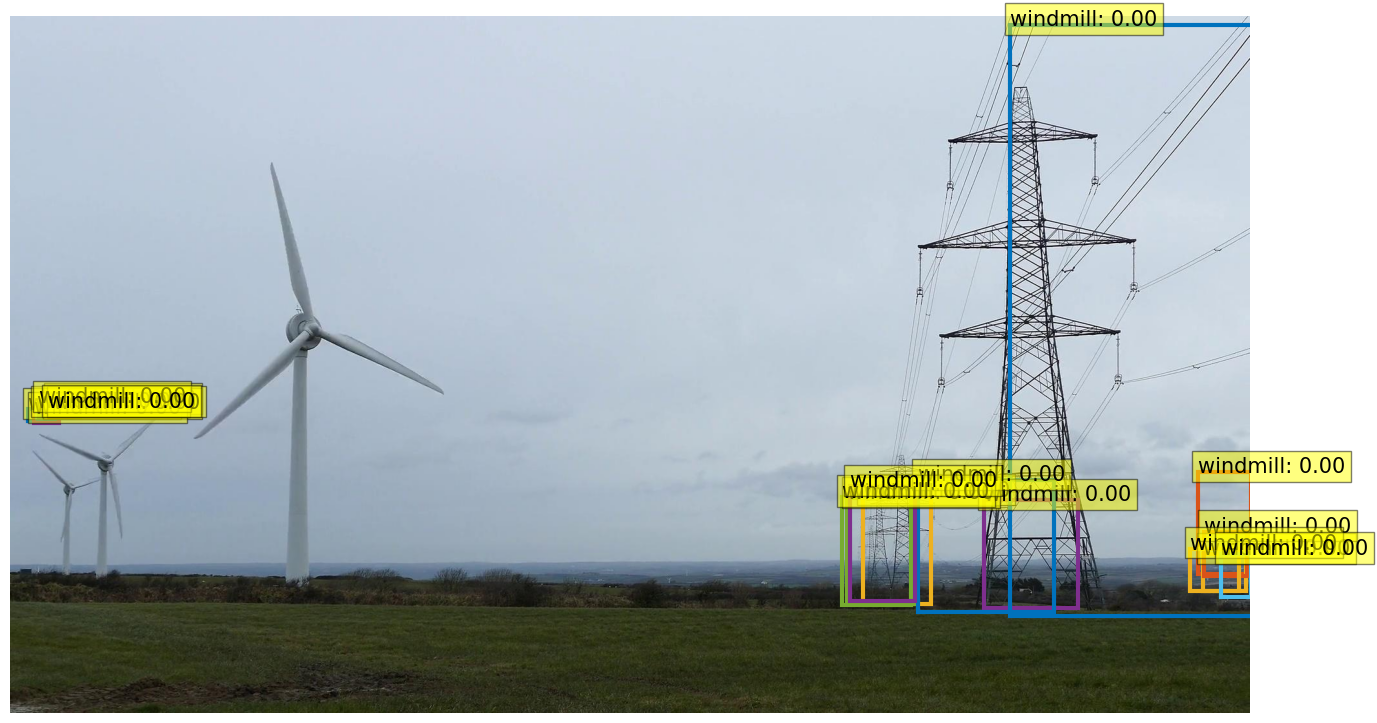

In [52]:
run_worflow(im, model)